# Final Project Part 2

## Description

Use diffusion to generate music


In [ ]:
from abc import abstractmethod
import math
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW

import os

from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import Compose, Resize, Lambda, ToTensor
from tqdm import tqdm

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [ ]:
# Hyperparameters
MAX_TIMESTEPS = 1500
lr = .0001

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip song_images.zip

Archive:  song_images.zip
replace song_images/83549.npz? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module


def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class TimestepBlock(nn.Module):
    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x


class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.op = nn.Conv2d(channels, channels, 3, stride=2, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels

        self.in_layers = nn.Sequential(
            nn.GroupNorm(128, channels),
            nn.SiLU(),
            nn.Conv2d(channels, self.out_channels, 3, padding=1)
        )
        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_channels, self.out_channels)
        )
        self.out_layers = nn.Sequential(
            nn.GroupNorm(128, self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(nn.Conv2d(self.out_channels, self.out_channels, 3, padding=1)),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        else:
            self.skip_connection = nn.Conv2d(channels, self.out_channels, kernel_size=1)

    def forward(self, x, emb):
        h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        h = h + emb_out
        h = self.out_layers(h)
        return self.skip_connection(x) + h


class UNetModel(nn.Module):
    """
    The full UNet model with timestep embedding.

    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    """

    def __init__(
        self,
        in_channels,
        hidden_channels,
        out_channels,
        num_res_blocks,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
    ):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = hidden_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.dropout = dropout
        self.channel_mult = channel_mult

        time_embed_dim = hidden_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(hidden_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        self.input_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, hidden_channels, 3, padding=1))
        ])
        input_block_chans = [hidden_channels]
        ch = hidden_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [ResBlock(ch, time_embed_dim, dropout, out_channels=mult * hidden_channels)]
                ch = mult * hidden_channels
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                self.input_blocks.append(TimestepEmbedSequential(Downsample(ch)))
                input_block_chans.append(ch)
                ds *= 2

        self.middle_block = TimestepEmbedSequential(
            ResBlock(ch, time_embed_dim, dropout),
            ResBlock(ch, time_embed_dim, dropout),
        )

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResBlock(
                        ch + input_block_chans.pop(),
                        time_embed_dim,
                        dropout,
                        out_channels=hidden_channels * mult,
                    )
                ]
                ch = hidden_channels * mult
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch))
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            nn.GroupNorm(128, ch),
            nn.SiLU(),
            zero_module(nn.Conv2d(hidden_channels, out_channels, 3, padding=1))
        )

    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.

        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x C x H x W] Tensor of outputs.
        """

        xs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        for module in self.input_blocks:
            x = module(x, emb)
            xs.append(x)
        x = self.middle_block(x, emb)
        for module in self.output_blocks:
            cat_in = torch.cat([x, xs.pop()], dim=1)
            x = module(cat_in, emb)
        return self.out(x)


# cosine scheduler


In [ ]:
def cosine_beta_schedule(timesteps):
    """
    Compute [β1,...,βT] using eq. 17 of "Improved Denoising Diffusion Probabilistic Models"
    """
    s = 0.008
    # define f
    def f(x):
      return torch.cos((x / timesteps + s)/(1 + s) * 0.5 * torch.pi)**2

    x = torch.linspace(0, timesteps, timesteps + 1)
    # calculate alpha
    alpha = f(x) / f(torch.tensor([0]))
    # calculate beta
    beta = 1 - alpha[1:] / alpha[:-1]
    beta = torch.clip(beta, 0.0001, 0.999)
    return beta


Global variables for $\beta$, $\alpha$, and $\bar{\alpha}$

In [ ]:
beta = cosine_beta_schedule(MAX_TIMESTEPS).to(device)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, 0)

# the forward diffusion (training) process

In [ ]:
def training(model, optimizer, dataloader, n_minibatches=2000):

    losses = []
    model.train()  # Let's the model know it is in training model

    batch_size = 20


    # Implement Algorithm 1 below. You can find what each symbol means in "Denoising Diffusion Probabilistic Models"
    # 1000-2000 minibatches (i.e. optimization steps) is sufficient for learning how to generate images, but more will help make better images
    # sample a batch of images
    for i in range(n_minibatches):

      x0 = next(iter(dataloader))
      x0 = x0.to(device)


      # sample from the uniform distribution a batch of timesteps between 1 and T
      timesteps = torch.randint(1, MAX_TIMESTEPS, (batch_size,)).to(device)

      # sample noise from the normal distribution (it needs to match the shape of the batch of images)
      noise = torch.randn_like(x0).to(device)

      # create xt
      xt = torch.sqrt(alpha_bar[timesteps].view(-1, 1, 1, 1)) * x0 + torch.sqrt(1 - alpha_bar[timesteps].view(-1, 1, 1, 1)) * noise

      et = model(xt, timesteps)

      # calculate the loss
      loss = F.mse_loss(et, noise)

      # take the gradient descent step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      losses.append(loss.item())


      print(f'{i} out of {n_minibatches}')

    return model, losses


# the backward diffusion (sampling) process

In [ ]:
@torch.no_grad()
def sampling(model, batch_size):
    model.eval()  # Let's the model know it is in validation mode

    # Implement Algorithm 2 below. You can find what each symbol means in "Denoising Diffusion Probabilistic Models"
    shape = (batch_size, 1, 128, 128)

    xt = torch.randn(shape, device=device)

    for t in range(MAX_TIMESTEPS - 1, 0, -1):
        z = torch.randn(shape, device=device)
        x0_hat = (1 / (alpha_bar[t] ** 0.5)) * (xt - ((1 - alpha_bar[t]) ** 0.5) * model(xt, torch.tensor([t] * batch_size, device=device)))
        x0_hat = torch.clamp(x0_hat, -1, 1)

        alpha_bar_minus = alpha_bar[t - 1] if t > 1 else 1

        xt = (beta[t] * alpha_bar_minus ** 0.5) / (1 - alpha_bar[t]) * x0_hat + (((alpha[t] ** 0.5) * (1 - alpha_bar_minus)) / (1 - alpha_bar[t])) * xt

        if t > 1:
            xt += (beta[t]**0.5) * z

        if t % 100 == 0:
          print(f"Sampling at t={t}")
          plt.imshow(xt[0].cpu().numpy().squeeze(), cmap="gray")
          plt.show()

    return xt



# Custom DataLoader

In [ ]:
class MidiDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_list = os.listdir(folder_path)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = os.path.join(self.folder_path, self.file_list[idx])
        data = np.load(file_name)
        sample = torch.from_numpy(data['arr_0']).float().unsqueeze(0)
        if sample.shape != (1, 128, 128):
          return self.__getitem__(idx + 1)
        return sample

# Part 4: Train and generate images

In [ ]:
model = UNetModel(
        in_channels=1,
        hidden_channels=128,
        out_channels=1,
        num_res_blocks=2,
        dropout=0.,
        channel_mult=(1, 2, 2, 2),
    ).to(device)

batch_size = 20
dataset = MidiDataset(folder_path='song_images/')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

optimizer = AdamW(model.parameters(), lr=lr)

In [ ]:
model, losses = training(model, optimizer, dataloader)

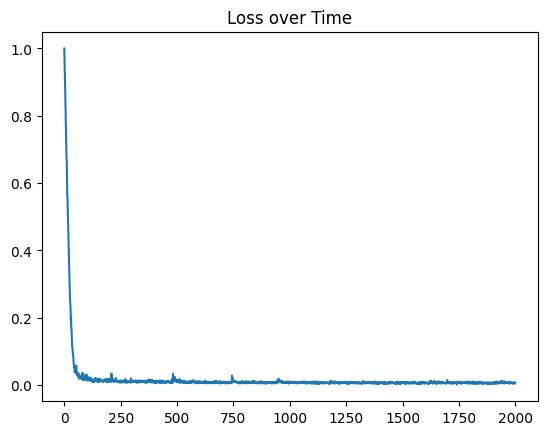

In [ ]:
# plot training loss
plt.plot(losses)
plt.title("Loss over Time")
plt.show()

Sampling at t=1400


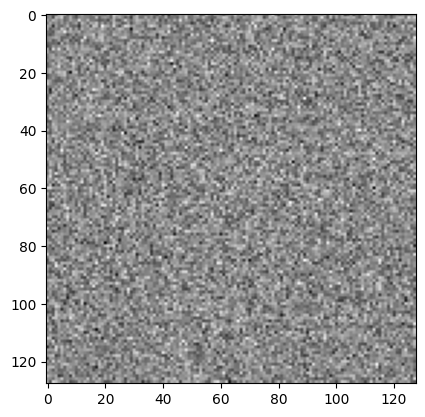

Sampling at t=1300


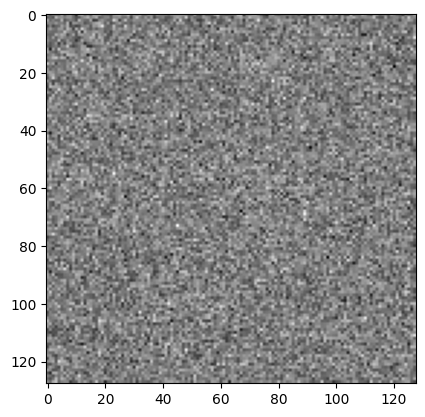

Sampling at t=1200


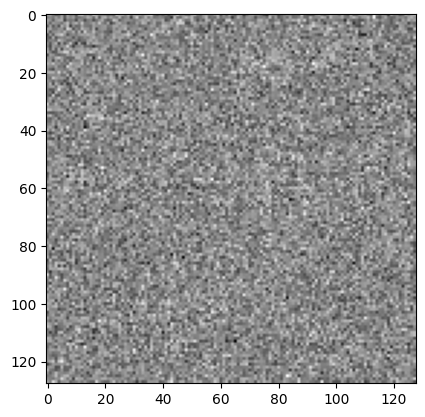

Sampling at t=1100


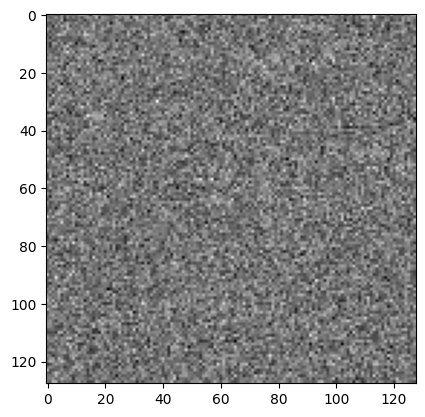

Sampling at t=1000


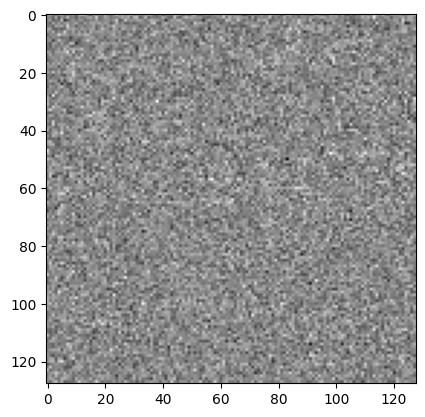

Sampling at t=900


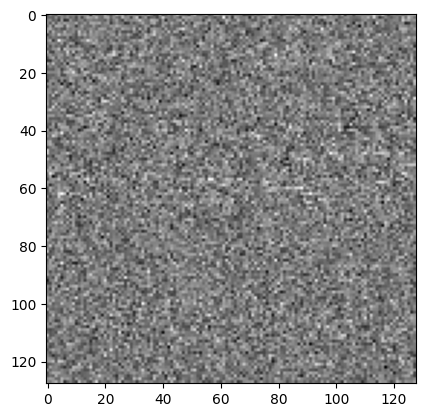

Sampling at t=800


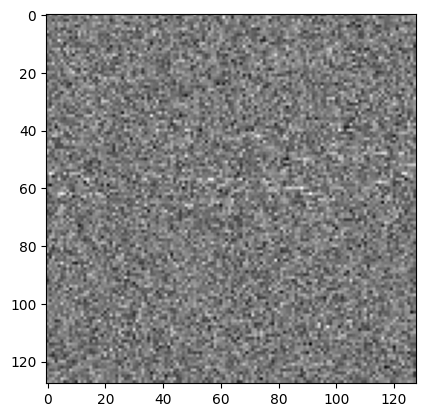

Sampling at t=700


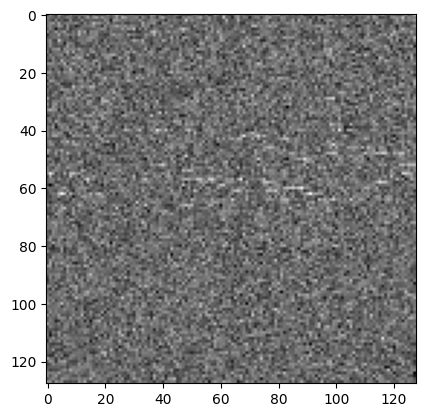

Sampling at t=600


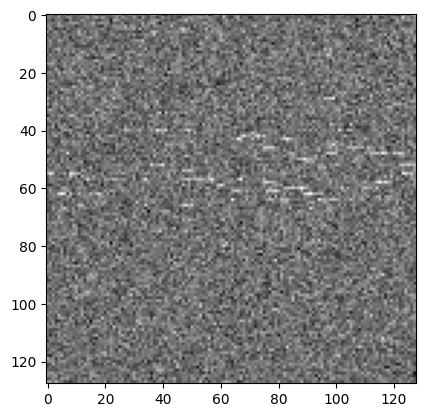

Sampling at t=500


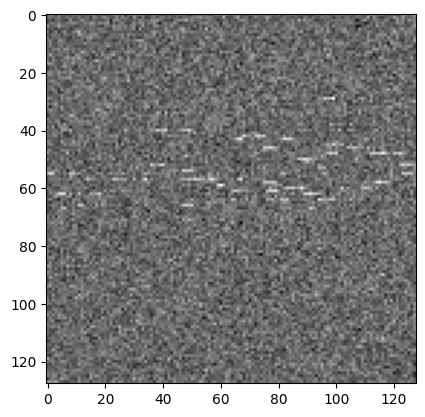

Sampling at t=400


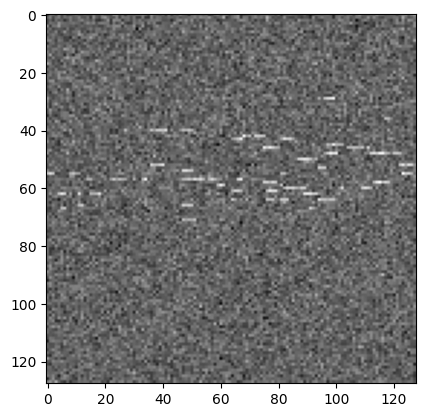

Sampling at t=300


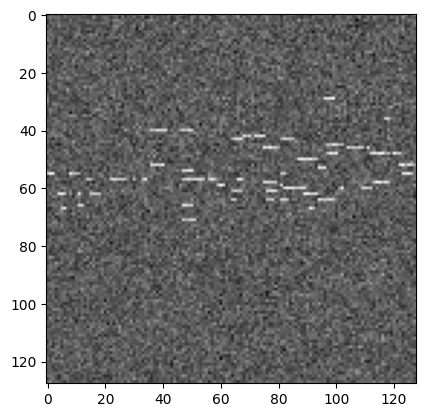

Sampling at t=200


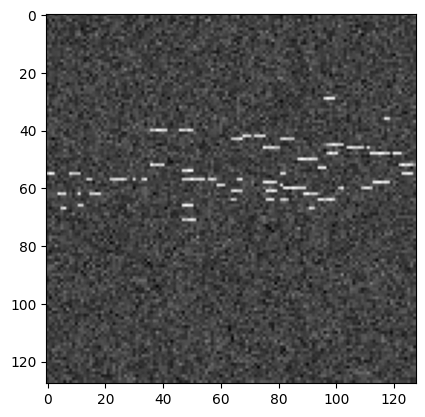

Sampling at t=100


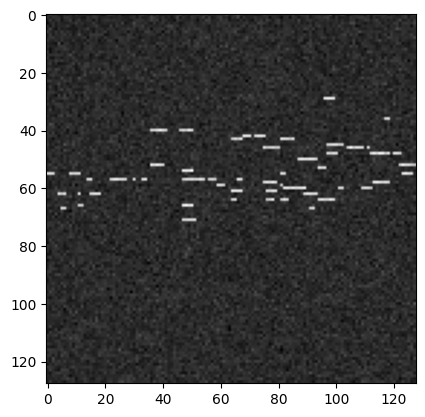

In [ ]:
images = sampling(model, 16)

In [ ]:
! pip install pretty_midi

In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth

# Music

In [ ]:
import fluidsynth
import pretty_midi
from IPython import display

SAMPLE_RATE = 16000

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI):
  waveform = pm.fluidsynth(fs=SAMPLE_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  return display.Audio(waveform, rate=SAMPLE_RATE)

In [ ]:
def img_to_midi(img, filename):
  img[img == 1] = 127
  img[img == -1] = 0
  midi = pretty_midi.PrettyMIDI()
  piano = pretty_midi.Instrument(0)
  midi.instruments.append(piano)
  notes, frames = img.shape

  prev_note = False
  start = 0

  for n in range(notes):
      for f in range(frames):
          if img[n, f] > 0 and not prev_note:
              start = f
              prev_note = True
          elif img[n, f] <= 0 and prev_note:
              end = f
              piano.notes.append(pretty_midi.Note(velocity=100, pitch=n, start=start/10, end=end/10))
              prev_note = False
  midi.write(filename + '.mid')

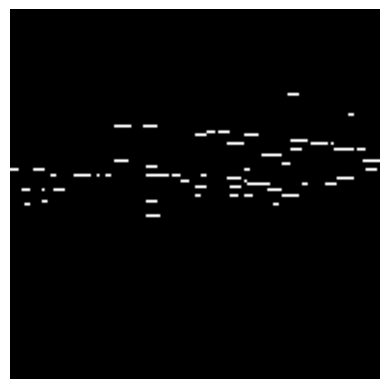

In [ ]:
img = images[0].cpu().squeeze().numpy()
img[img>0] = 1
img[img<=0] = -1

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
img_to_midi(img, 'ai_0')

In [ ]:
pm = pretty_midi.PrettyMIDI('ai_0.mid')
display_audio(pm)

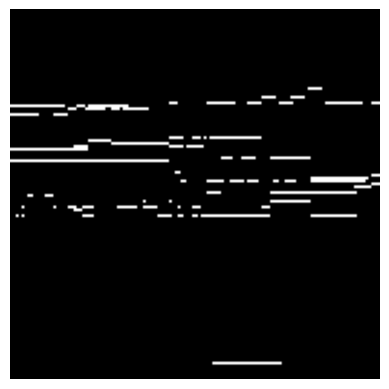

In [ ]:
img = images[4].cpu().squeeze().numpy()
img[img>0] = 1
img[img<=0] = -1

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
img_to_midi(img, 'ai_4')

In [ ]:
pm = pretty_midi.PrettyMIDI('ai_4.mid')
display_audio(pm)

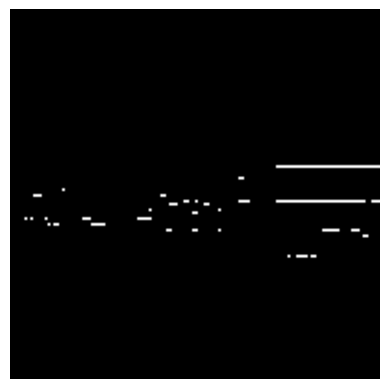

In [ ]:
img = images[8].cpu().squeeze().numpy()
img[img>0] = 1
img[img<=0] = -1

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
img_to_midi(img, 'ai_8')

In [ ]:
pm = pretty_midi.PrettyMIDI('ai_8.mid')
display_audio(pm)

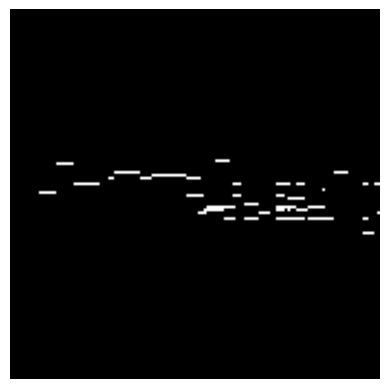

In [ ]:
img = images[9].cpu().squeeze().numpy()
img[img>0] = 1
img[img<=0] = -1

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
img_to_midi(img, 'ai_9')

In [ ]:
pm = pretty_midi.PrettyMIDI('ai_9.mid')
display_audio(pm)

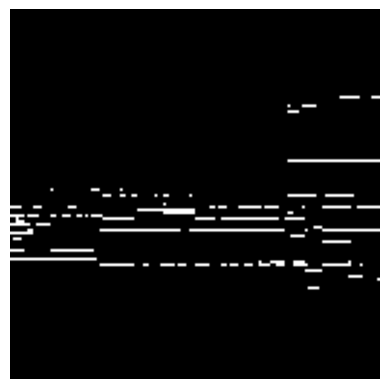

In [ ]:
img = images[11].cpu().squeeze().numpy()
img[img>0] = 1
img[img<=0] = -1

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
img_to_midi(img, 'ai_11')

In [ ]:
pm = pretty_midi.PrettyMIDI('ai_11.mid')
display_audio(pm)

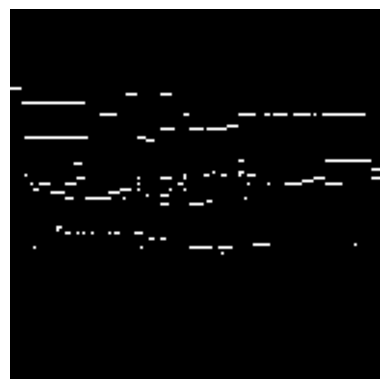

In [ ]:
img = images[12].cpu().squeeze().numpy()
img[img>0] = 1
img[img<=0] = -1

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
img_to_midi(img, 'ai_12')

In [ ]:
pm = pretty_midi.PrettyMIDI('ai_12.mid')
display_audio(pm)

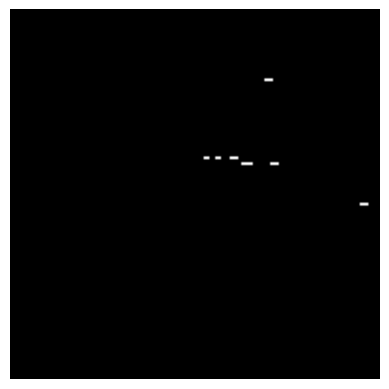

In [ ]:
img = images[15].cpu().squeeze().numpy()
img[img>0] = 1
img[img<=0] = -1

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
img_to_midi(img, 'ai_15')

In [ ]:
pm = pretty_midi.PrettyMIDI('ai_15.mid')
display_audio(pm)